In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from pylab import *
import seaborn as sns
from matplotlib import cm
import scipy.stats as st
import csv

plt.rcParams.update({'font.size': 7})
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams["xtick.major.size"] = 2
plt.rcParams["ytick.major.size"] = 2
plt.rcParams["xtick.major.width"] = 0.5
plt.rcParams["ytick.major.width"] = 0.5

antibody = "CH65"
antigens = ["G189E"] 
L = 16
df = pd.read_csv("../../Kd_Inference/results_CH65/Kd_processed/20220603_CH65_QCfilt_REPfilt.csv", dtype={"geno":"str"})
df['G189E_mean_neg']=-df['G189E_mean']

In [2]:
def get_additive_expectation(df,mutation_lookat_list,fixed_mutation_dict):
    
    hue = [_label(s, mutation_lookat_list, fixed_mutation_dict) for s in df.geno] 
    df = df.assign(hue=hue)
    
    num_muts = len(mutation_lookat_list)
    
    names = []
    dist_means = []
    #dist_deltas = []
    dist_expectations = []
    
    #germ
    UCA_dist = -1*df.loc[df["hue"]=='UCA']["G189E_mean_neg"]
    UCA_mean = np.mean(UCA_dist)
    dist_means.append(UCA_mean)
    names.append('UCA')
    dist_expectations.append(np.nan)
    
    #singles
    for i in range(len(mutation_lookat_list)):
        name = str(mutation_lookat_list[i])
        dist = -1*df.loc[df["hue"]==name]["G189E_mean_neg"]
        dist_means.append(np.mean(dist))
        names.append(name)
        #dist_deltas.append(np.mean(dist)-UCA_mean)
        dist_expectations.append(np.nan)
        
    # doubles
    for i in range(len(mutation_lookat_list)):
        for j in range(i+1,len(mutation_lookat_list)):
            name = str(mutation_lookat_list[i])+','+str(mutation_lookat_list[j])
            dist = -1*df.loc[df["hue"]==name]["G189E_mean_neg"]
            dist_means.append(np.mean(dist))
            names.append(name)
            dist_expectations.append(np.mean(UCA_dist)+(dist_means[i+1]-UCA_mean)+(dist_means[j+1]-UCA_mean))
            
    
    # triple
    name = ','.join([str(x) for x in mutation_lookat_list])
    dist = -1*df.loc[df["hue"]==name]["G189E_mean_neg"]
    dist_means.append(np.mean(dist))
    names.append(name)
    
     
    expect_third = UCA_mean
    expect = UCA_mean
    for i in range(len(mutation_lookat_list)):
        expect_third += dist_means[i+1]-UCA_mean
        expect += dist_means[i+1]-UCA_mean
    for i in range(len(mutation_lookat_list)):
        expect_third += dist_means[i+4]-dist_expectations[i+4]
    dist_expectations.append(expect)
    
    return(names,dist_means,dist_expectations,expect_third)




In [3]:
df

,geno,repa_x,repb_x,MA90_mean,MA90_sem,repa_y,repb_y,SI06_mean,SI06_sem,repa,...,pos9,pos10,pos11,pos12,pos13,pos14,pos15,pos16,som_mut,G189E_mean_neg
0,0000000000000000,8.612721,8.472320,8.542521,0.070200,6.000000,6.000000,6.000000,0.000000,6.000000,...,0,0,0,0,0,0,0,0,0,-6.000000
1,0000000000000001,8.631980,8.516378,8.574179,0.057801,6.000000,6.000000,6.000000,0.000000,6.000000,...,0,0,0,0,0,0,0,1,1,-6.000000
2,0000000000000010,8.340245,8.290790,8.315518,0.024727,6.000000,6.000000,6.000000,0.000000,6.000000,...,0,0,0,0,0,0,1,0,1,-6.000000
3,0000000000000011,8.511183,8.436571,8.473877,0.037306,6.000000,6.000000,6.000000,0.000000,6.000000,...,0,0,0,0,0,0,1,1,2,-6.000000
4,0000000000000100,8.552056,8.523392,8.537724,0.014332,6.000000,6.000000,6.000000,0.000000,6.000000,...,0,0,0,0,0,1,0,0,1,-6.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65531,0010111011111000,NaN,NaN,NaN,NaN,8.905138,8.479383,8.692261,0.212877,9.975117,...,1,1,1,1,1,0,0,0,9,-9.950192
65532,1011000111101111,NaN,NaN,NaN,NaN,7.817147,8.091421,7.954284,0.137137,9.044403,...,1,1,1,0,1,1,1,1,11,-9.200316
65533,1100100111010000,NaN,NaN,NaN,NaN,6.000000,6.000000,6.000000,0.000000,7.780187,...,1,1,0,1,0,0,0,0,7,-7.625410
65534,1100110111111010,NaN,NaN,NaN,NaN,6.000000,6.000000,6.000000,0.000000,9.718486,...,1,1,1,1,1,0,1,0,11,-9.718486


## violin plots

In [4]:
import itertools as it
def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return it.chain.from_iterable(it.combinations(s, r) for r in range(len(s)+1))

['UCA', '7', '9', '11', '7,9', '7,11', '9,11', '7,9,11'] [6.002704018279358, 6.3116709093151115, 6.007110694016662, 7.438323246959216, 6.49623660657302, 8.148985463501866, 7.60158535756688, 8.224030457208022] [nan, nan, nan, nan, 6.316077585052415, 7.74729013799497, 7.44272992269652, 7.7516968137322735] 8.492406595630136


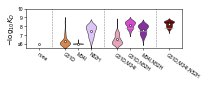

In [5]:
colordict = {'red':'#e6194B', 'green':'#3cb44b', 'yellow':'#ffe119', 'blue':'#4363d8', 
             'orange':'#f58231', 'cyan':'#42d4f4', 'magenta':'#f032e6', 'pink':'#fabed4', 
             'teal':'#469990', 'lavender':'#dcbeff', 'brown':'#9A6324', 'beige':'#fffac8', 
             'maroon':'#800000', 'mint':'#aaffc3', 'navy':'#000075', 'black':'#000000','white':'#ffffff',
             'olive':'#808000','lime':'#bfef45','purple':'#911eb4',
            'darkbeige':'#ccc8a0','lightyellow':'#ffea5e','lightnavy':'#333399','lightpurple':'#a74bc3',
            'lightmagenta':'#f35beb','darkpink':'#f299b9'}

mutation_lookat = [7,9,11]
fixed_mutations = {3:'0',4:"0",5:"0",8:"0",10:'0',15:"0",16:"0"}

def _label(s, mut_lookat, fixed):
    for a in fixed:
        if s[a-1] != fixed[a]:
            return np.nan#"empty"
    lab = ""
    for a in mut_lookat:
        if s[a-1] == "1":
            lab += f"{a},"
    if lab == "":
        lab = "UCA"
    else:
        lab = lab[:-1]
    return lab

hue = [_label(s, mutation_lookat, fixed_mutations) for s in df.geno]

order_1 = ['-','',
           '7','9','11','',
           '7,9','7,11','9,11','',
           '7,9,11']
labels_1 = ['none',
           'G31D','M34I','N52H',
           'G31D,M34I','G31D,N52H','M34I,N52H',
           'G31D,M34I,N52H']

palette_1 = ['lightyellow','white','orange','pink','lavender','white','darkpink','magenta','purple','white','maroon']
xvals = [0,2,3,4,6,7,8,10]

# get means
names,means,expects,third = get_additive_expectation(df,mutation_lookat,fixed_mutations)
print(names,means,expects,third)
fig = plt.figure(figsize=(2.9,1.2))
ax = plt.subplot(111)
sns.violinplot(x=hue, y=-df.G189E_mean_neg, ax=ax, order=order_1, palette = [colordict[x] for x in palette_1],
               inner=None,linewidth=0.5,scale='width') 
# for i in range(8):
#     ax.collections[i].set_edgecolor('black')
    
plt.plot([0,2,3,4,6,7,8,10],means,color='w',marker='o',linewidth=0,markersize=2,markeredgecolor='k',markeredgewidth=0.5)
xvals = [0,2,3,4,6,7,8,10]
# add lines for additive expectations
width=0.35
for i in range(len(xvals)):
    plt.plot([xvals[i]-width,xvals[i]+width],[expects[i],expects[i]],color='darkgrey',linestyle='-',linewidth=0.5) 
plt.plot([10-width,10+width],[third,third],'k--',linewidth=0.5) 


for i in [1,5,9]:
    plt.plot([i,i],[5,11],linestyle='--',color='grey',linewidth=0.5)

plt.ylabel(r'$-\log_{10}K_D$',labelpad=0)
plt.ylim([5.5,10])
ax.tick_params(pad=1)
plt.yticks([6,7,8,9,10],['≤6','7','8','9','10'],fontsize=5)
plt.title('',fontsize=7)
plt.xticks([0,2,3,4,6,7,8,10],labels_1,rotation=-35,ha='left',rotation_mode="anchor",fontsize=5)

plt.xlim([-1,11])
plt.tight_layout()


plt.savefig('images/G189E_look%s_fix%s.png' % (mutation_lookat, fixed_mutations),dpi=1200)
plt.show()